In [ ]:
import tensorflow as tf
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is available


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tensorflow.keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
sns.set(style="dark")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DOL/Project1/

/content/drive/MyDrive/DOL/Project1


In [ ]:
data = pd.read_csv('nwdaf_data/nwdaf_data.csv')
data = data.drop(columns='has_anomaly')

In [ ]:
cell0 = data.loc[data['cell_id']==0]
cell1 = data.loc[data['cell_id']==1]
cell2 = data.loc[data['cell_id']==2]
cell3 = data.loc[data['cell_id']==3]
cell4 = data.loc[data['cell_id']==4]

In [ ]:
load_cell0 = cell0.groupby('t')['load'].sum()
load_cell1 = cell1.groupby('t')['load'].sum()
load_cell2 = cell2.groupby('t')['load'].sum()
load_cell3 = cell3.groupby('t')['load'].sum()
load_cell4 = cell4.groupby('t')['load'].sum()

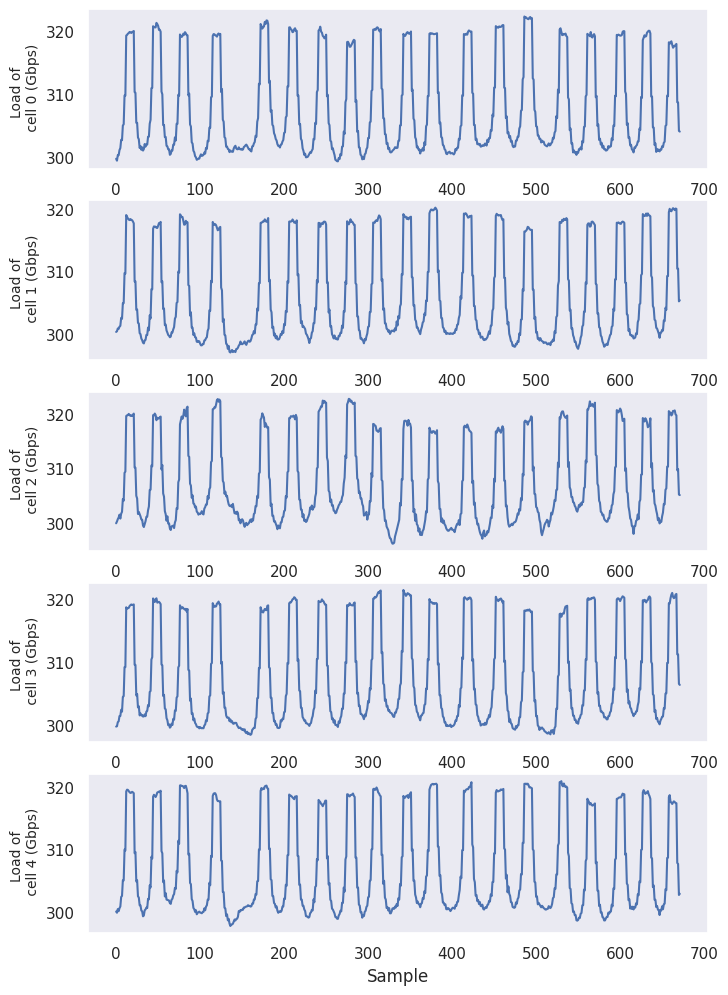

In [ ]:
week = 4*24*7
plt.figure(figsize=(8, 12))

plt.subplot(5, 1, 1)
plt.plot(load_cell0[:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 0 (Gbps)", fontsize=10)

plt.subplot(5, 1, 2)
plt.plot(load_cell1[:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 1 (Gbps)", fontsize=10)

plt.subplot(5, 1, 3)
plt.plot(load_cell2[:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 2 (Gbps)", fontsize=10)

plt.subplot(5, 1, 4)
plt.plot(load_cell3[:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 3 (Gbps)", fontsize=10)

plt.subplot(5, 1, 5)
plt.plot(load_cell4[:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 4 (Gbps)", fontsize=10)
plt.show();

The pre-processing method is almost equivalent to centralized learning. The only difference is that the scaling operations are performed individually on each base station. In contrast, in centralized learning the scaling is performed by considering the combined data from all base stations.


In [ ]:
load_cell0 = load_cell0.to_numpy().reshape(-1, 1)
load_cell1 = load_cell1.to_numpy().reshape(-1, 1)
load_cell2 = load_cell2.to_numpy().reshape(-1, 1)
load_cell3 = load_cell3.to_numpy().reshape(-1, 1)
load_cell4 = load_cell4.to_numpy().reshape(-1, 1)

scaler0 = MinMaxScaler()
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
scaler4 = MinMaxScaler()

scaled_load_cell0 =  scaler0.fit_transform(load_cell0)
scaled_load_cell1 =  scaler1.fit_transform(load_cell1)
scaled_load_cell2 =  scaler2.fit_transform(load_cell2)
scaled_load_cell3 =  scaler3.fit_transform(load_cell3)
scaled_load_cell4 =  scaler4.fit_transform(load_cell4)


In [ ]:
look_back = 2*week
def df_to_X_y(df, look_back=5):
  # df_as_np = df.to_numpy()
  df_as_np = df
  X = []
  y = []
  for i in range(len(df_as_np)-look_back):
    row = [[a] for a in df_as_np[i:i+look_back]]
    X.append(row)
    label = df_as_np[i+look_back]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
def create_model(x_train, y_train ,n_epoch = 20, n_batch = 64, lr=0.001, validation_split = 0.2, verbosity = 2):

  loss_function = MeanSquaredError()
  optimizer = Adam(learning_rate=lr)

  model = Sequential()
  model.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(LSTM(units = 50))
  model.add(Dropout(0.3))
  model.add(Dense(units = 8, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1, activation = 'linear'))
  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=[RootMeanSquaredError()])
  print(model.summary())
  history_model = model.fit(x_train, y_train, epochs=n_epoch, batch_size=n_batch, shuffle=False, verbose= verbosity, validation_split= validation_split)
  return history_model, model

In [ ]:
x_cell0, y_cell0 = df_to_X_y(scaled_load_cell0, look_back)
x_cell1, y_cell1 = df_to_X_y(scaled_load_cell1, look_back)
x_cell2, y_cell2 = df_to_X_y(scaled_load_cell2, look_back)
x_cell3, y_cell3 = df_to_X_y(scaled_load_cell3, look_back)
x_cell4, y_cell4 = df_to_X_y(scaled_load_cell4, look_back)

In [ ]:
x_train_cell0, x_test_cell0, y_train_cell0, y_test_cell0 = train_test_split(x_cell0, y_cell0, test_size=0.2, shuffle=False)
x_train_cell1, x_test_cell1, y_train_cell1, y_test_cell1 = train_test_split(x_cell1, y_cell1, test_size=0.2, shuffle=False)
x_train_cell2, x_test_cell2, y_train_cell2, y_test_cell2 = train_test_split(x_cell2, y_cell2, test_size=0.2, shuffle=False)
x_train_cell3, x_test_cell3, y_train_cell3, y_test_cell3 = train_test_split(x_cell3, y_cell3, test_size=0.2, shuffle=False)
x_train_cell4, x_test_cell4, y_train_cell4, y_test_cell4 = train_test_split(x_cell4, y_cell4, test_size=0.2, shuffle=False)


In [ ]:
x_train_cell0 = x_train_cell0.reshape(x_train_cell0.shape[0],x_train_cell0.shape[1],x_train_cell0.shape[2])
x_train_cell1 = x_train_cell1.reshape(x_train_cell1.shape[0],x_train_cell1.shape[1],x_train_cell1.shape[2])
x_train_cell2 = x_train_cell2.reshape(x_train_cell2.shape[0],x_train_cell2.shape[1],x_train_cell2.shape[2])
x_train_cell3 = x_train_cell3.reshape(x_train_cell3.shape[0],x_train_cell3.shape[1],x_train_cell3.shape[2])
x_train_cell4 = x_train_cell4.reshape(x_train_cell4.shape[0],x_train_cell4.shape[1],x_train_cell4.shape[2])

In [ ]:
history_model_cell0, model_cell0 = create_model(x_train_cell0, y_train_cell0)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1344, 50)          10400     
                                                                 
 lstm_13 (LSTM)              (None, 1344, 50)          20200     
                                                                 
 lstm_14 (LSTM)              (None, 1344, 50)          20200     
                                                                 
 lstm_15 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 408       
                                                                 
 dropout_7 (Dropout)         (None, 8)                

In [ ]:
history_model_cell1, model_cell1 = create_model(x_train_cell1, y_train_cell1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 1344, 50)          10400     
                                                                 
 lstm_17 (LSTM)              (None, 1344, 50)          20200     
                                                                 
 lstm_18 (LSTM)              (None, 1344, 50)          20200     
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 8)                 408       
                                                                 
 dropout_9 (Dropout)         (None, 8)                

In [ ]:
history_model_cell2, model_cell2 = create_model(x_train_cell2, y_train_cell2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1344, 50)          10400     
                                                                 
 lstm_21 (LSTM)              (None, 1344, 50)          20200     
                                                                 
 lstm_22 (LSTM)              (None, 1344, 50)          20200     
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 408       
                                                                 
 dropout_11 (Dropout)        (None, 8)                

In [ ]:
history_model_cell3, model_cell3 = create_model(x_train_cell3, y_train_cell3)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 1344, 50)          10400     
                                                                 
 lstm_25 (LSTM)              (None, 1344, 50)          20200     
                                                                 
 lstm_26 (LSTM)              (None, 1344, 50)          20200     
                                                                 
 lstm_27 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_12 (Dropout)        (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 8)                 408       
                                                                 
 dropout_13 (Dropout)        (None, 8)                

In [ ]:
history_model_cell4, model_cell4 = create_model(x_train_cell4, y_train_cell4)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 1344, 50)          10400     
                                                                 
 lstm_29 (LSTM)              (None, 1344, 50)          20200     
                                                                 
 lstm_30 (LSTM)              (None, 1344, 50)          20200     
                                                                 
 lstm_31 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_14 (Dropout)        (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 8)                 408       
                                                                 
 dropout_15 (Dropout)        (None, 8)                

In [ ]:
x_test_cell0 = x_test_cell0.reshape(x_test_cell0.shape[0],x_test_cell0.shape[1],x_test_cell0.shape[2])
x_test_cell1 = x_test_cell1.reshape(x_test_cell1.shape[0],x_test_cell1.shape[1],x_test_cell1.shape[2])
x_test_cell2 = x_test_cell2.reshape(x_test_cell2.shape[0],x_test_cell2.shape[1],x_test_cell2.shape[2])
x_test_cell3 = x_test_cell3.reshape(x_test_cell3.shape[0],x_test_cell3.shape[1],x_test_cell3.shape[2])
x_test_cell4 = x_test_cell4.reshape(x_test_cell4.shape[0],x_test_cell4.shape[1],x_test_cell4.shape[2])

In [ ]:
cell0_predictions = model_cell0.predict(x_test_cell0).flatten()
cell0_results = pd.DataFrame(data={'Test Predictions':cell0_predictions, 'Actuals':y_test_cell0.reshape(y_test_cell0.shape[0])})

cell1_predictions = model_cell1.predict(x_test_cell1).flatten()
cell1_results = pd.DataFrame(data={'Test Predictions':cell1_predictions, 'Actuals':y_test_cell1.reshape(y_test_cell1.shape[0])})

cell2_predictions = model_cell0.predict(x_test_cell2).flatten()
cell2_results = pd.DataFrame(data={'Test Predictions':cell2_predictions, 'Actuals':y_test_cell2.reshape(y_test_cell2.shape[0])})

cell3_predictions = model_cell0.predict(x_test_cell3).flatten()
cell3_results = pd.DataFrame(data={'Test Predictions':cell3_predictions, 'Actuals':y_test_cell3.reshape(y_test_cell3.shape[0])})

cell4_predictions = model_cell0.predict(x_test_cell4).flatten()
cell4_results = pd.DataFrame(data={'Test Predictions':cell4_predictions, 'Actuals':y_test_cell4.reshape(y_test_cell4.shape[0])})

100/100 [==============================] - 6s 60ms/step


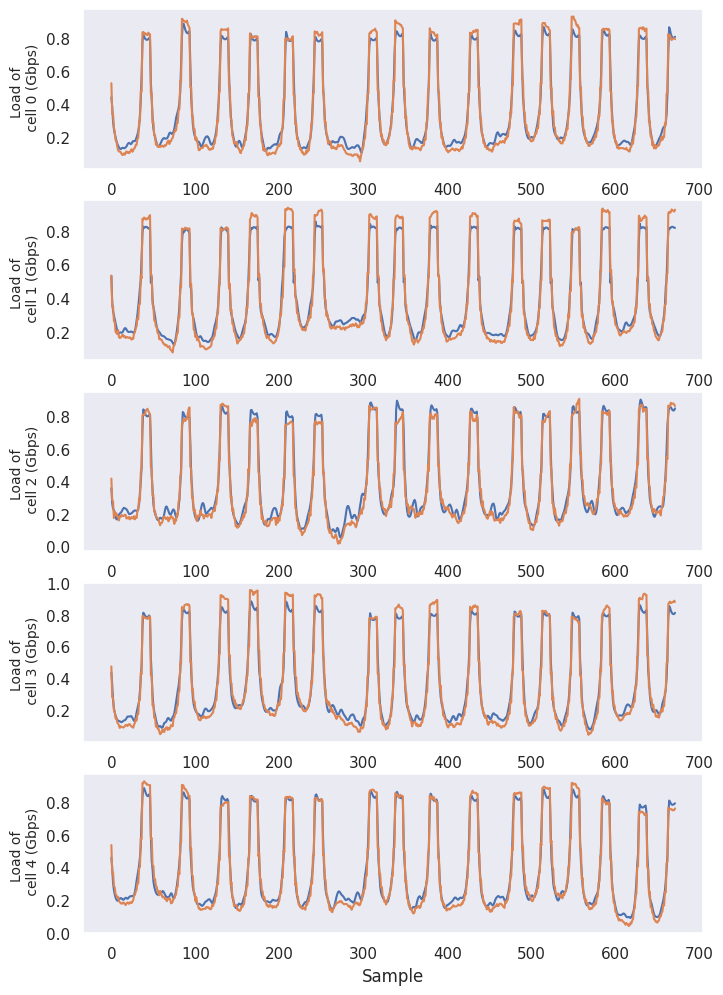

In [ ]:
week = 4*24*7
plt.figure(figsize=(8, 12))

plt.subplot(5, 1, 1)
plt.plot(cell0_results['Test Predictions'][:week])
plt.plot(cell0_results['Actuals'][:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 0 (Gbps)", fontsize=10)

plt.subplot(5, 1, 2)
plt.plot(cell1_results['Test Predictions'][:week])
plt.plot(cell1_results['Actuals'][:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 1 (Gbps)", fontsize=10)

plt.subplot(5, 1, 3)
plt.plot(cell2_results['Test Predictions'][:week])
plt.plot(cell2_results['Actuals'][:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 2 (Gbps)", fontsize=10)

plt.subplot(5, 1, 4)
plt.plot(cell3_results['Test Predictions'][:week])
plt.plot(cell3_results['Actuals'][:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 3 (Gbps)", fontsize=10)

plt.subplot(5, 1, 5)
plt.plot(cell4_results['Test Predictions'][:week])
plt.plot(cell4_results['Actuals'][:week])
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 4 (Gbps)", fontsize=10)
plt.show();

#######Bug in week. remove it!!

In [ ]:
inv_pred_cell0 = scaler0.inverse_transform(cell0_results['Test Predictions'][:week].to_numpy().reshape(-1,1))
inv_acc_cell0 = scaler0.inverse_transform(cell0_results['Actuals'][:week].to_numpy().reshape(-1,1))

inv_pred_cell1 = scaler1.inverse_transform(cell1_results['Test Predictions'][:week].to_numpy().reshape(-1,1))
inv_acc_cell1 = scaler1.inverse_transform(cell1_results['Actuals'][:week].to_numpy().reshape(-1,1))

inv_pred_cell2 = scaler2.inverse_transform(cell2_results['Test Predictions'][:week].to_numpy().reshape(-1,1))
inv_acc_cell2 = scaler2.inverse_transform(cell2_results['Actuals'][:week].to_numpy().reshape(-1,1))

inv_pred_cell3 = scaler3.inverse_transform(cell3_results['Test Predictions'][:week].to_numpy().reshape(-1,1))
inv_acc_cell3 = scaler3.inverse_transform(cell3_results['Actuals'][:week].to_numpy().reshape(-1,1))

inv_pred_cell4 = scaler4.inverse_transform(cell4_results['Test Predictions'][:week].to_numpy().reshape(-1,1))
inv_acc_cell4 = scaler4.inverse_transform(cell4_results['Actuals'][:week].to_numpy().reshape(-1,1))

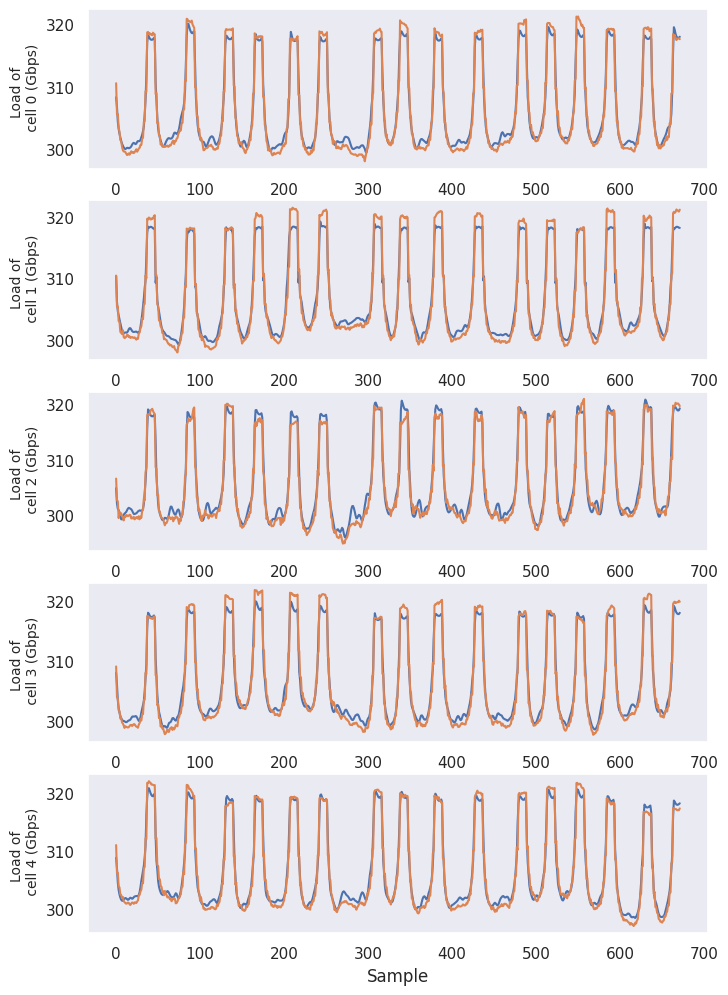

In [ ]:
week = 4*24*7
plt.figure(figsize=(8, 12))

plt.subplot(5, 1, 1)
plt.plot(inv_pred_cell0)
plt.plot(inv_acc_cell0)
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 0 (Gbps)", fontsize=10)

plt.subplot(5, 1, 2)
plt.plot(inv_pred_cell1)
plt.plot(inv_acc_cell1)
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 1 (Gbps)", fontsize=10)

plt.subplot(5, 1, 3)
plt.plot(inv_pred_cell2)
plt.plot(inv_acc_cell2)
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 2 (Gbps)", fontsize=10)

plt.subplot(5, 1, 4)
plt.plot(inv_pred_cell3)
plt.plot(inv_acc_cell3)
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 3 (Gbps)", fontsize=10)

plt.subplot(5, 1, 5)
plt.plot(inv_pred_cell4)
plt.plot(inv_acc_cell4)
plt.xlabel("Sample")
plt.ylabel("Load of \n cell 4 (Gbps)", fontsize=10)
plt.show();

In [ ]:
print("MSE for cell0: ", mean_squared_error(y_pred=inv_pred_cell0, y_true=inv_acc_cell0))
print("MSE for cell1: ", mean_squared_error(y_pred=inv_pred_cell1, y_true=inv_acc_cell1))
print("MSE for cell2: ", mean_squared_error(y_pred=inv_pred_cell2, y_true=inv_acc_cell2))
print("MSE for cell3: ", mean_squared_error(y_pred=inv_pred_cell3, y_true=inv_acc_cell3))
print("MSE for cell4: ", mean_squared_error(y_pred=inv_pred_cell4, y_true=inv_acc_cell4))

MSE for cell0:  1.4849365774159535
MSE for cell1:  1.7970723214407716
MSE for cell2:  1.9697631320458664
MSE for cell3:  1.8954009423159022
MSE for cell4:  1.4426171596056816
